#패션 의류 분류 경진 (0.8344)

##1. 기본 준비



In [130]:
import torch.nn.init
import torch
import numpy as np
import pandas as pd
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt



In [131]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

아래 두 블럭의 코드를 통해 구글 드라이브와 구글 코랩을 연결시킨다.

구글 드라이브 내의 fashion 폴더에 저장된 데이터들이 불러와 읽어지고, 저장된다.

In [132]:
from google.colab import drive
drive.mount('/content/drive')
#구글 드라이브에 csv 파일을 저장해두고 사용하기 위해 작성하는 코드


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [133]:
PATH = '/content/drive/MyDrive/fashion/'
train = pd.read_csv(PATH + "train.csv")
test = pd.read_csv(PATH + "test.csv")
submitfile = pd.read_csv(PATH + "sample_submission.csv")


아래 코드를 통해 csv 파일이 어떻게 구성되어 있는지 확인한다.

In [13]:
train.head()

,index,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,6,0,0,0,0,0,0,0,5,...,0,0,0,30,43,0,0,0,0,0
3,3,0,0,0,0,1,2,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,4,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
image_size = 28
channel = 1
learningrate = 0.01
trainingepochs = 10
batchsize = 100

##2. 데이터 준비


아래 코드를 통해 불러온 훈련셋과 테스트셋을 훈련할 수 있도록 데이터의 객체를 구성한다.
데이터들의 객체는 Dataset에게서 상속받는다.

In [183]:
class train_data(Dataset):

  def __init__(self, data, transform =None):
    self.fashion_mnist = list(data.values)
    self.transform = transform
    label, Image = [], []

    for Line in self.fashion_mnist:
      label.append(Line[1])
      Image.append(Line[2:])

    self.label = np.asarray(label)

    self.Image = np.asarray(Image)
    self.Image = self.Image.reshape(-1, image_size, image_size, channel).astype('float32')

  def __len__(self):
    return len(self.label)

  def __getitem__(self, index):
    label, image = self.label[index], self.Image[index]

    if self.transform:
      image = self.transform(image)

    return label, image

  def printitem(self, index):
    image = self.Image[index].reshape(image_size, image_size)
    plt.imshow(image, cmap = 'gray')
  

printitem 함수는 n번째 데이터에 해당하는 이미지를 matplotlib으로 출력한다.

testset은 trainset과 달리 label 정보를 가지고 있지 않아 image 정보만 다루며 csv 파일의 구성도 달라져 슬라이싱을 하는 범위를 달리하였다.

In [184]:
class test_data(Dataset):
  def __init__(self, data, transform =None):
    self.fashion_mnist = list(data.values)
    self.transform = transform
    Image = []

    for Line in self.fashion_mnist:
      Image.append(Line[1:])

    self.Image = np.asarray(Image)
    self.Image = self.Image.reshape(-1, image_size, image_size, channel).astype('float32')

  def __len__(self):
    return len(self.fashion_mnist)

  def __getitem__(self,index):
    image = self.Image[index]

    if(self.transform):
      image = self.transform(image)

    return image

scale을 통해 ndarray 형인 데이터를 텐서 형으로 변환하여주며, [0,255]에 해당하는 값을 [0,1]로 스케일링 해준다.

DataLoader는 데이터들의 주소와 값을 차례대로 접근하도록 해준다. 학습시 DataLoader를 enumerate() 함수에 넣어 for문에 사용하게된다.

In [187]:
scale = transforms.Compose([transforms.ToTensor(), ])

fashion_train_data = train_data(train, scale)
fashion_test_data = test_data(test, scale)

train_dataloader = DataLoader(dataset = fashion_train_data, batch_size = batchsize, shuffle = False)
test_dataloader = DataLoader(dataset = fashion_test_data, batch_size = 1, shuffle = False)

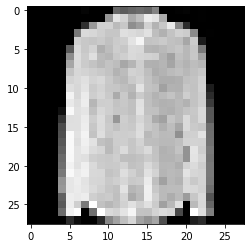

In [143]:
fashion_train_data.printitem(2)

##3.모델 구축, 학습


아래 블록에선 CNN 모델을 만든다. torch.nn.Module에서 상속받아 구성한다.
2개의 convolution layer와 1개의 fullyconnectedlayer로 구성하였다.

In [190]:
class CNN(torch.nn.Module):

  def __init__(self):
    super(CNN,self).__init__()
    self.layer1 = torch.nn.Sequential(
        torch.nn.Conv2d(1, 64, kernel_size = 3, stride=1, padding = 1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
    )

    self.layer2 = torch.nn.Sequential(
        torch.nn.Conv2d(64, 64, kernel_size = 3, stride=1, padding = 1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
    )

    self.fc = torch.nn.Linear(7*7 * 64, 10, bias=True)
    #fully connected layer

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0), -1)
    #fully connected layer의 Linear 연산을 위해 일차원 배열로 구성을 바꿈
    out = self.fc(out)
    return out

학습은
1. 데이터를 넣어 결과값 도출
2. 결과값의 오차를 계산
3. 기울기를 초기화, (이번엔 0으로 초기화 하였다)
4. 오차역전파 진행
5. 변화값을 반영

위 과정들을 반복하여 진행하며, 위에서 선언한 model에 변화를 주면서 진행하게된다.

100개의 데이터를 훈련할때마다 당시 Loss와 몇번째 epoch를 진행하고 있는지 출력한다. (아래 코드에선 range함수를 기본 형태로 사용하여 0부터 9까지만 출력되었다.)

In [193]:
model = CNN().to(device)

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learningrate)

for epoch in range(trainingepochs):
  for batch, (label, image) in enumerate(train_dataloader):
      label, image = label.to(device), image.to(device)
      out = model(image)                              #1
      loss = criterion(out, label)                    #2

      optimizer.zero_grad() #기울기 0으로 초기화      #3
      loss.backward() #오차역전파                     #4
      optimizer.step()                                #5

      if batch%100==0:
        print("Loss:{:.4f}, Epochs = [{}/{}]".format(loss.item(), epoch, trainingepochs))


Loss:18.8818, Epochs = [0/10]
Loss:0.9617, Epochs = [0/10]
Loss:0.8157, Epochs = [0/10]
Loss:0.7315, Epochs = [0/10]
Loss:0.8014, Epochs = [0/10]
Loss:0.7131, Epochs = [0/10]
Loss:0.7360, Epochs = [1/10]
Loss:0.6431, Epochs = [1/10]
Loss:0.6449, Epochs = [1/10]
Loss:0.6650, Epochs = [1/10]
Loss:0.6106, Epochs = [1/10]
Loss:0.6498, Epochs = [1/10]
Loss:0.6177, Epochs = [2/10]
Loss:0.6385, Epochs = [2/10]
Loss:0.5657, Epochs = [2/10]
Loss:0.5872, Epochs = [2/10]
Loss:0.5347, Epochs = [2/10]
Loss:0.5447, Epochs = [2/10]
Loss:0.6248, Epochs = [3/10]
Loss:0.6432, Epochs = [3/10]
Loss:0.5134, Epochs = [3/10]
Loss:0.5437, Epochs = [3/10]
Loss:0.5389, Epochs = [3/10]
Loss:0.4900, Epochs = [3/10]
Loss:0.6242, Epochs = [4/10]
Loss:0.6227, Epochs = [4/10]
Loss:0.4634, Epochs = [4/10]
Loss:0.5484, Epochs = [4/10]
Loss:0.5505, Epochs = [4/10]
Loss:0.5181, Epochs = [4/10]
Loss:0.5919, Epochs = [5/10]
Loss:0.6422, Epochs = [5/10]
Loss:0.4509, Epochs = [5/10]
Loss:0.4645, Epochs = [5/10]
Loss:0.5546, 

#4.예측과 저장

학습이 완료된 모델에 테스트셋을 넣어 예측을 진행한다.

torch.no_grad()를 사용하면 기울기 연산을 하지 않게된다. 이를 통해 더 빠르게 예측을 진행할 수 있다.

예측한 값들은 predicted 리스트에 넣어 저장한다.

In [199]:
predicted = [];

with torch.no_grad(): #기울기에 영향을 주지 않도록 한다.
  for image in test_dataloader:
    image = image.to(device)
    out = model(image)

    result = np.asarray(torch.argmax(out, dim=1).cpu())
    predicted.append(result)

predicted = np.array(predicted).flatten()
print(predicted.shape)

(10000,)


아래 두 코드를 통해 헤더가 'label'인 행의 값을 예측값으로 바꾸었으며,
바뀐 값을 submission.csv 파일에 저장되었다.

저장된 csv파일을 DACON에 제출하여 마무리하였으며, 0.8344에 해당하는 점수가 나왔다.

In [202]:
submitfile['label'] = predicted

In [203]:
submitfile.to_csv(PATH + "submission.csv", index=False)